# `Projet 7 : Implementez un modèle de scoring`

**Notebook Modélisation**

Ce notebook est destinée à la modélisation des données traités et nettoyés  selon le notebook " *P7_n2_traitement_nettoyage*  "

Les étapes : 

- 1er Partie: Mise en Place et Installation des bibliotheques necessaires

- 2ème Partie: Telechargement des fichiers 

- 3ème Partie: Modélisation: Entrainement de plusieurs modèles de classification

- 4ème Partie: Sauvegarde du meilleur modèle avec joblib

- 5ème Partie : Résultats du modèle LGBM sur les données non balancés

- 6ème Partie: Feature Selection avec SelectionfromModel

- 7ème Partie: Optimisation du Threshold

- 8ème Partie: Sauvegarde du jeu de données pour préparer le Dashboard. 

# `1er Partie: Mise en place et Installation de l'environnement`

---

Avec la :
- Instalation de libraries utiles à l'acquisition de la données ainsi que les différents traitements statistiques et visualisation nécessaire dans un premier temps (Pandas & Numpy)
- Confirmation et changement de "directory si necessaire avec os.getwd()
- Amélioration d'options d'affichage avec 'pd.set_option'

In [ ]:
# Outils mathématiques et manipulation de données
import pandas as pd
import numpy as np
import scipy as sp

# Librairies graphiques
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns
from textwrap import wrap

# Cross-validation et hyperparamétrisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# Librairie de Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Metriques de Segmentation
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

# Réduction de dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

In [ ]:
#savoir où est mon "directory"
import os
os.getcwd()

'/content'

In [ ]:
# Changer 'directory' sur google lab:
# 1st of all: connect to google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Options d'affichage des outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
sns.color_palette("rocket") # choix de la palette de couleurs sns

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [ ]:
%pwd

'/content'

In [ ]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

# `2ème Partie: Telechargement`


On telecharge les données que nous avons auparavant rassemnlé.

In [ ]:
X_train = pd.read_csv('drive/My Drive/Projet_7/X_train.csv', index_col= "SK_ID_CURR")
X_test = pd.read_csv('drive/My Drive/Projet_7/X_test.csv', index_col= "SK_ID_CURR")
y_train = pd.read_csv('drive/My Drive/Projet_7/y_train.csv', index_col= "SK_ID_CURR")

In [ ]:
print( "Shape X_train:", X_train.shape, "\n","Shape X_test:", X_test.shape, "\n", "Shape y_train:", y_train.shape)

Shape X_train: (307511, 90) 
 Shape X_test: (48744, 90) 
 Shape y_train: (307511, 1)


## `Selection des variables numériques:`

In [ ]:
# Seletionner seulement les variables numériques 

numerical_columns = list(X_train.select_dtypes(include=[np.number]).columns)
numerical_columns2 = list(X_test.select_dtypes(include=[np.number]).columns)

In [ ]:
print(len(numerical_columns))

286


In [ ]:
X_train_f = X_train[numerical_columns]
X_test_f = X_test[numerical_columns2]

# `3ème Partie : Modélisation`

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

## `Pré- traitement:`


In [ ]:
#train_set
X_train = X_train_f.copy()
X_train.replace([np.inf, -np.inf], np.nan, inplace=True) #remplacer les valeurs infinis par NaN

#test_set
X_test = X_test_f.copy()
X_test.replace([np.inf, -np.inf], np.nan, inplace=True) #remplacer les valeurs infinis par NaN

In [ ]:
for variables in numerical_columns:
  mean = X_train[variables].mean()
  X_train[variables] = X_train[variables].fillna(mean) # remplacer les missings values par la mode. 

In [ ]:
for variables2 in numerical_columns2:
  mean = X_test[variables].mean()
  X_test[variables2] = X_test[variables2].fillna(mean) # remplacer les missings values par la mode. 

In [ ]:
# Starndardiser avec StandarScaler:
std_scaler = StandardScaler()
X_train_scaled= std_scaler.fit_transform(X_train.to_numpy())
X_test_scaled= std_scaler.fit_transform(X_test.to_numpy())

### `Desequilibre des données?`

In [ ]:
#Definition parametres graphique
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12
             }

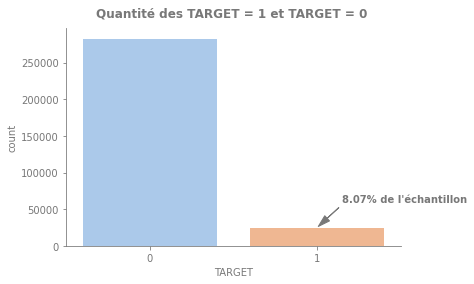

In [ ]:
#fleche pour identifier les parametres: 
with plt.rc_context(rc_params):
  
  #Figure et axes
  fig, ax = plt.subplots()

   # Création du graphique "countplot"
  sns.countplot(x = 'TARGET', 
                data = y_train,
                ax = ax,
                palette = "pastel")
  
  ax.set_title("Quantité des TARGET = 1 et TARGET = 0 ") #Graph Title

  #Sauvegarde de la % du échantillon
  percentual_default = round((y_train['TARGET'].value_counts()[1] / y_train.shape[0])*100,2)

  #Création de l'information dans le graphique:
  ax.annotate(str(percentual_default) + "% de l'échantillon", 
              xy = (1, y_train['TARGET'].value_counts()[1]), 
              xytext = (25,25), 
              color = "#787878",
              weight = 'bold', 
              textcoords='offset points',
              arrowprops=dict(color = '#787878',  shrink= 0.05, width = 0.01, headwidth = 7))

 plt.show()

- Nous pouvons observer par le graphique au-dessus la variable dependante de notre modèle "TARGET" n'est pas équilibré, une fois qui seulement 8.07% du total des données font reference aux clients avec problèmes de payement (TARGET=1) 

- Cela genere un problème pour la prédiction du modèle. Les données étant désequilibrés, l'algo va classifier la majorité des données comme target =0. Donc nous avons besoin de balancer les données. 

`Pour balancer les données` ont utilisera la technique de under - sampling due à la possibilité de maintenir integralement les données originales associées à la variable "TARGET"

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 0)

#Equilibre de l'échantillon
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
print(len(X_train_rus), len(X_train))

49650 307511


In [ ]:
#Transformation du array vers un dataframe et y e serie.pd
X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)

In [ ]:
y_train_rus = pd.DataFrame(y_train_rus, columns = y_train.columns)

In [ ]:
y_train_rus.head(3)

,TARGET
0,0
1,0
2,0


In [ ]:
# Checker si le y_train_rus est balancé:

y_train_rus.value_counts(normalize=True)  #ok

TARGET
0        0.50
1        0.50
dtype: float64

##` A- Entraînement de plusieurs modèles sur les données balancés `

`Métriques d'évaluations des modèles :` Accuracy	AUC	Recall	Prec.

La métrique d'évaluation choisi pour définir l'algorithme le plus performant pour nos données est la ROC_AUC, parce que nous souhaitons que notre modèle aye une bonne capacité de separabilité entre les classes. 


On teste les modèles suivantes : 
- Regression Logistique
- Random Forest
- KNN
- LightGBM

In [ ]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Importation des modèles de classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
#Création d'une liste pas remplie pour sauvegarder les métriques et noms des modèles:
name_model = []
accuracy = []

#Modèles entraînés :

model_dm = DummyClassifier(strategy='most_frequent',random_state=14)

model_rl = LogisticRegression(random_state = 42)

model_rf = RandomForestClassifier(random_state = 42)

model_knn = KNeighborsClassifier()

model_lgbm = LGBMClassifier(random_state = 42)

#Création d'un loop pour appliquer cross-validations en chaque modèle et sauvegarder le résultat:
for model in [model_dm, model_rl, model_rf, model_knn,  model_lgbm]:

   #Application du cross-validation pour calculer le score: 
  score = cross_val_score(estimator = model,
                          X = X_train_rus,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  #Sauvegarde du nom du modèle: 
  name_model.append(model.__class__.__name__)

  #Sauvegarde du score du modèle:
  accuracy.append(score.mean())


df_model = pd.DataFrame(data = accuracy, 
                        index = name_model, 
                        columns = ['ROC_AUC'])


df_model # résultats pour la métrique ROC_AUC pour toutes les modèles entraînés: 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

,ROC_AUC
DummyClassifier,0.50
LogisticRegression,0.64
RandomForestClassifier,0.75
KNeighborsClassifier,0.58
LGBMClassifier,0.77


### `Prédiction des targets : `

In [ ]:
# Les Y prédits
y_predit_dm_rus = model_dm.predict(X_train_rus)
y_predit_lr_rus = model_rl.predict(X_train_rus)
y_predit_rf_rus = model_rf.predict(X_train_rus)
y_predit_knn_rus = model_knn.predict(X_train_rus)
y_predit_lgbm_rus = model_lgbm.predict(X_train_rus)

### `Les métriques d'évaluation: `

In [ ]:
# Accuracy Score:
ac_dm_rus = accuracy_score(y_train_rus, y_predit_dm_rus)
ac_lr_rus = accuracy_score(y_train_rus, y_predit_lr_rus)
ac_rf_rus = accuracy_score(y_train_rus, y_predit_rf_rus)
ac_knn_rus = accuracy_score(y_train_rus, y_predit_knn_rus)
ac_lgbm_rus = accuracy_score(y_train_rus, y_predit_lgbm_rus)


print(ac_dm_rus, ac_lr_rus, ac_rf_rus, ac_knn_rus, ac_lgbm_rus)

0.5 0.6000201409869084 1.0 0.7210070493454179 0.7531319234642497


In [ ]:
# Précision Score :
pr_dm_rus = precision_score(y_train_rus, y_predit_dm_rus)
pr_lr_rus = precision_score(y_train_rus, y_predit_lr_rus)
pr_rf_rus = precision_score(y_train_rus, y_predit_rf_rus)
pr_knn_rus = precision_score(y_train_rus, y_predit_knn_rus)
pr_lgbm_rus = precision_score(y_train_rus, y_predit_lgbm_rus)

print(pr_dm_rus, pr_lr_rus, pr_rf_rus, pr_knn_rus, pr_lgbm_rus)

0.0 0.6095473396276361 1.0 0.720456463213726 0.7530198099532937


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# F1 Score :
f1_dm_rus = f1_score(y_train_rus, y_predit_dm_rus)
f1_lr_rus = f1_score(y_train_rus, y_predit_lr_rus)
f1_rf_rus = f1_score(y_train_rus, y_predit_rf_rus)
f1_knn_rus = f1_score(y_train_rus, y_predit_knn_rus)
f1_lgbm_rus = f1_score(y_train_rus, y_predit_lgbm_rus)

print(f1_dm_rus, f1_lr_rus, f1_rf_rus, f1_knn_rus, f1_lgbm_rus)

0.0 0.5818365585058222 1.0 0.7213550048278081 0.7531866051831417


In [ ]:
# Recall score  :
rec_dm_rus = recall_score(y_train_rus, y_predit_dm_rus)
rec_lr_rus = recall_score(y_train_rus, y_predit_lr_rus)
rec_rf_rus = recall_score(y_train_rus, y_predit_rf_rus)
rec_knn_rus = recall_score(y_train_rus, y_predit_knn_rus)
rec_lgbm_rus = recall_score(y_train_rus, y_predit_lgbm_rus)

print(rec_dm_rus, rec_lr_rus, rec_rf_rus, rec_knn_rus, rec_lgbm_rus)

0.0 0.5565357502517624 1.0 0.7222557905337361 0.7533534743202417



`Comparaison des métriques pour mesurer la qualité des modèles sur le jeu d'entrainement`


Model | AUC | Accuracy Score | Precision Score| F1 Score | Recall Score
--- | --- |--- |--- |--- |--- |
`DummyClassifier` | 0.50 |0.5 | 0.0 |  0.0 | 0.0 |
`LogisticRegression` | 0.64 | 0.60 | 0.60| 0.58 | 0.55|
`RandomForestClassifier` | 0.75 |1.0 | 1.0 | 1.0 | 1.0|
`KNeighborsClassifier` | 0.58 | 0.72 | 0.72 | 0.72 | 0.72|
`LGBMClassifier` | 0.77 |  0.75 | 0.75 | 0.75 | 0.75 |

## `B - Optimisation des hyperparamètres : `


Le modèle avec les meilleurs résultats c'est le LGBM . On utilisera GridSearchCV pour choisir l'ensemble de parametres optmisés: 

In [ ]:
#Définition des hyperparamètres à optimiser avec GridSearch: 
param_grid = {'num_leaves': (40, 45, 50),
             'min_child_samples': (300, 400, 500), 
             'min_child_weight': [0.3, 0.2, 0.1],
             'max_depth': (11, 12), 
             'reg_alpha': [4, 5, 6],
             'reg_lambda': [1, 2, 3]}

#GridSearch
clf2 = GridSearchCV(estimator = LGBMClassifier(random_state = 42),
                   param_grid = param_grid,
                   scoring = 'roc_auc',
                   n_jobs = -1,
                   cv = k_fold
                   )

#Optmisation sera basé sur les données balancés X_train_rus et y_train_rus 
clf2.fit(X = X_train_rus, 
        y = y_train_rus)

##Les meilleurs hyperparametres: 
clf2.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'max_depth': 12,
 'min_child_samples': 500,
 'min_child_weight': 0.3,
 'num_leaves': 50,
 'reg_alpha': 5,
 'reg_lambda': 3}

In [ ]:
#Score avec les meilleurs parâmetres 
clf2.best_score_

0.7749323807517652



```
Les meilleurs paramètres pour le modèle LGBM sont:
```


- 'max_depth': 12,
- 'min_child_samples': 500,
- 'min_child_weight': 0.3,
- 'num_leaves': 50,
- 'reg_alpha': 5,
- 'reg_lambda': 3

# `4ème Partie: Sauvegarder le meilleur modèle LGBM`

In [ ]:
model_lgbm = LGBMClassifier(random_state = 42, 
                            max_depth= 12,
                            min_child_samples=500,
                            min_child_weight=0.3,
                            reg_alpha= 5,
                            reg_lambda = 3)

In [ ]:
import joblib
 
# Save the model as a pickle in a file
#joblib.dump(model_lgbm, 'drive/My Drive/Projet_7/models/lgbm_model.pkl')
 
# Load the model from the file
model_lgbm = joblib.load('drive/My Drive/Projet_7/models/lgbm_model.pkl')

# `5ème partie: Résultats du modèle sur les données non balancés:`

X_train et y_train

In [ ]:
# Utiliser le modèle uploadé pour faire des prédictions 
y_test_predit = model_lgbm.predict(X_test[mask])

In [ ]:
y_train_predit = model_lgbm.predict(X_train)

In [ ]:
y_train_reel = y_train["TARGET"].to_numpy()

#### `Métriques d'évaluation sur données d'entrainement:`

In [ ]:
print ("Accuracy Score: ", accuracy_score(y_train_reel, y_train_predit), "\n", "precision score: ", precision_score(y_train_reel, y_train_predit), "\n", "F1_Score :" ,f1_score(y_train_reel, y_train_predit) , "\n", "recall_score :" , recall_score(y_train_reel, y_train_predit))

Accuracy Score:  0.7095941283401244 
 precision score:  0.18214891351500573 
 F1_Score : 0.2926663128796939 
 recall_score : 0.7442094662638469


#### `Matrice de confusion:`

In [ ]:
# Calcul de la matrice de confusion:
mat_conf = confusion_matrix(y_train_reel, y_train_predit)

# Mise sous forme de DataFrame
mat_conf = pd.DataFrame(mat_conf)

In [ ]:
mat_conf

,0,1
0,199733,82953
1,6350,18475


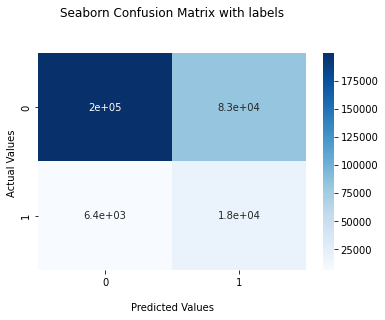

In [ ]:
import seaborn as sns

ax = sns.heatmap(mat_conf, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

#` 6ème Partie: featuring selection`

## `Select from model`

Pour selectionner les variables adaptés aux données nous allons utilise la méthode Select from model sur les données balancés : 

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

#kfold
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
 var_num = X_train_rus.columns.values.tolist()
 print(var_num)

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMEN

In [ ]:
from sklearn.feature_selection import SelectFromModel

#Sauvegarde de la quantité de Ks features testés ensemble:
k_val = []

#Sauvegarde des scores pour chaque Ks features testés ensemble: 
score_val = []

#Loop pour executer les features 2 par 2
for k in range(2, X_train_rus.shape[1], 2):

  
  selector = SelectFromModel(model_lgbm, 
                             max_features = k, 
                             threshold = -np.inf)
  
  #Entraînement avec SelectFromModel
  selector.fit(X_train_rus, y_train_rus)

  #Sauvegarde features choisis
  mask = X_train_rus.columns[selector.get_support()].to_list()

  #Selectionne les fectures choisis et cree un nouveau X_train
  X_train_rus_selector = X_train_rus[mask]
  
  # ""
  s1 = set(mask)
  s2 = set(var_num)

  if (s1.intersection(s2) == set()):

    #Definitions des étapes de la pipeline :
    pipe = make_pipeline(model)
  
  else:

    #Standadisation des variables:
    num_scaled = ColumnTransformer([("Padronizar", StandardScaler(), list(s1.intersection(s2)))],
                         remainder='passthrough')

    #Definition des étapes de la pipeline
    pipe = make_pipeline(num_scaled, model_lgbm)

  #Application du cross-validation pour calculer le score: 
  score = cross_val_score(estimator = pipe,
                          X = X_train_rus_selector,
                          y = y_train_rus,
                          scoring = 'roc_auc',
                          cv = k_fold)
  
  #Sauvegarde K
  k_val.append(k)

  #Sauvegarde score
  score_val.append(score.mean())

#Création dun dataframe:
df_feature_selection = pd.DataFrame(data = score_val, index = k_val, columns = ['Score'])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

In [ ]:
df_feature_selection.to_csv('drive/My Drive/Projet_7/df_feature_selection.csv')

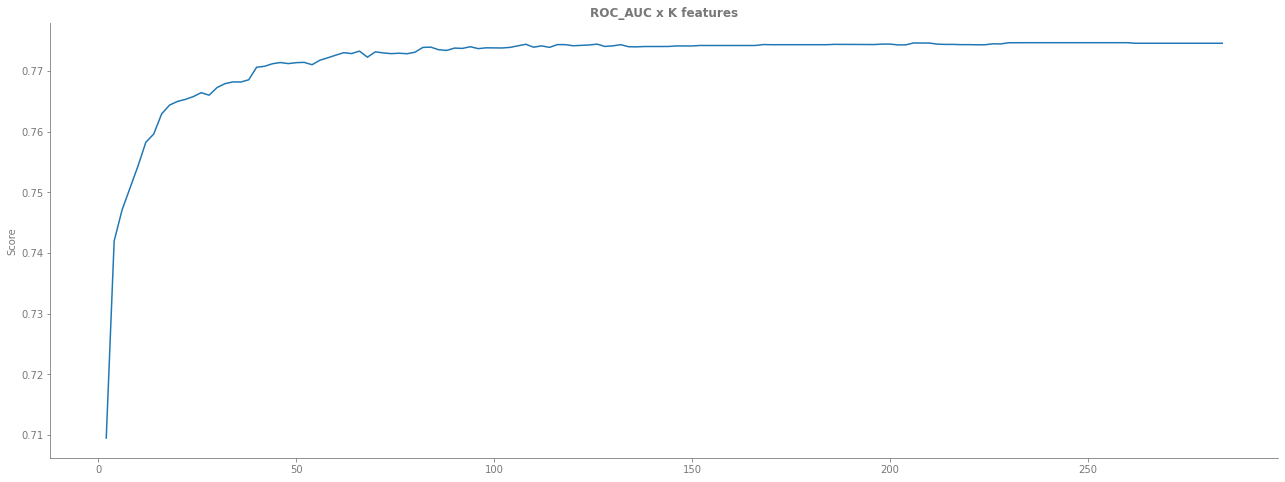

In [ ]:
#Definindo os parâmetros de style para o matplotlib
rc_params = {'axes.edgecolor':'#787878', 
             'axes.titlecolor':'#787878', 
             'axes.labelcolor': '#787878', 
             'axes.spines.top':False, 
             'axes.spines.right': False, 
             'xtick.color': '#787878', 
             'ytick.color': '#787878',
             'axes.titleweight': 'bold',
             'axes.titlesize': 12
             }

#Aplicando os parâmetros no matplotlib/seaborn
with plt.rc_context(rc_params):

  #instanciando o axes e figure do matplotlib
  fig, ax = plt.subplots(figsize = (22,8))

  #Construindo o gráfico 
  sns.lineplot(
                x = df_feature_selection.index.to_list(),
                y = df_feature_selection['Score'],
                ci = None,
                ax = ax,
              )
  
  #Colocando o título no gráfico
  ax.set_title("ROC_AUC x K features")

  #Exibindo o gráfico
  plt.show()




On observe que la courbe AUC s'stabilise aux allentours de 90 -100 features. On choisi un nombre k qui stabilise la valeur de AUC et qu'au même temps réduit le nombre de features pour simplifier notre modèle.

La prochaine étape sera de vérifier quelles sont les colonnes choisis:


---




In [ ]:
#Selector
selector = SelectFromModel(model_lgbm, 
                           max_features = 90, 
                           threshold = -np.inf)
  
#Entrainer SelectFromModel
selector.fit(X_train_rus, y_train_rus)

#Sauvegarde les features choisis:
mask = X_train_rus.columns[selector.get_support()].to_list()

#Print features choisis
mask

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'TOTALAREA_MODE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'Bureau_CB_DAYS_CREDIT__abs_min',
 'Bureau_CB_DAYS_CREDIT_ENDDATE__max',
 'Bureau_CB_DAYS_ENDDATE_FACT__min',
 'Bureau_CB_AMT_CREDIT_MAX_OVERDUE__mean',
 'Bureau_CB_AMT_CREDIT_MAX_OVERDUE__max',
 'Bureau_CB_AMT_CREDIT_SUM__mean',
 'Bureau_CB_AMT_CREDIT_SUM__sum',
 'Bureau_CB_AMT_CREDIT_SUM_DEBT__sum',
 'Bureau_CB_AMT_CREDIT_SUM_LIMIT__sum',
 'Bureau_CB_STATUS__size__sum',
 'Bureau_CB_CR_TY_Car loan__sum',
 'Bureau_CB_CR_TY_Microloan__sum',
 'Bureau_CB_CR_TY_Mortgage__sum',
 'Bureau_CB_CR_ACT_Active__sum',
 'Bureau_CB_CR_ACT_

In [ ]:
print(len(mask))

90


In [ ]:
# sauvegarder liste de variables "mask" en tant que file pour après : 
#joblib.dump(mask, 'drive/My Drive/Projet_7/models/mask_list.pkl')
 
# Telecharger la liste: 
mask = joblib.load('drive/My Drive/Projet_7/models/mask_list.pkl')

print(len(mask))

90


## `Ranking des variables par importance :`

In [ ]:
# DF avec les variables choisis avec SelectfromModel:
X_train_rus_selector = X_train_rus[mask]

In [ ]:
model_lgbm.fit(X_train_rus_selector, y_train_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(max_depth=12, min_child_samples=500, min_child_weight=0.3,
               random_state=42, reg_alpha=5, reg_lambda=3)

### `Feature importance`

In [ ]:
feat_imp_fs = pd.Series(model_lgbm.feature_importances_, index=X_train_rus_selector.columns)

In [ ]:
feat_imp_fs.sort_values(ascending=False)

PAYMENT_RATE                                   178
EXT_SOURCE_3                                   144
EXT_SOURCE_2                                   123
DAYS_BIRTH                                     108
PA_PrLI_DELAY_DAYS_INSTALMENT__max__max        100
AMT_ANNUITY                                     73
PA_AMT_DIFF_PCT__mean                           71
Bureau_CB_DAYS_CREDIT_ENDDATE__max              69
PA_DAYS_LAST_DUE_1ST_VERSION__max               67
PA_PrLCash_N_CONTR_ST_Active__sum__sum          66
Bureau_CB_AMT_CREDIT_SUM_DEBT__sum              63
DAYS_LAST_PHONE_CHANGE                          57
DAYS_ID_PUBLISH                                 55
ANNUITY_INCOME_PERC                             55
AMT_GOODS_PRICE                                 53
DAYS_EMPLOYED_PERC                              52
Gender_                                         52
DAYS_EMPLOYED                                   50
PA_AMT_DIFF_PCT__max                            46
AMT_CREDIT                     

In [ ]:
print(len(feat_imp_fs))

90


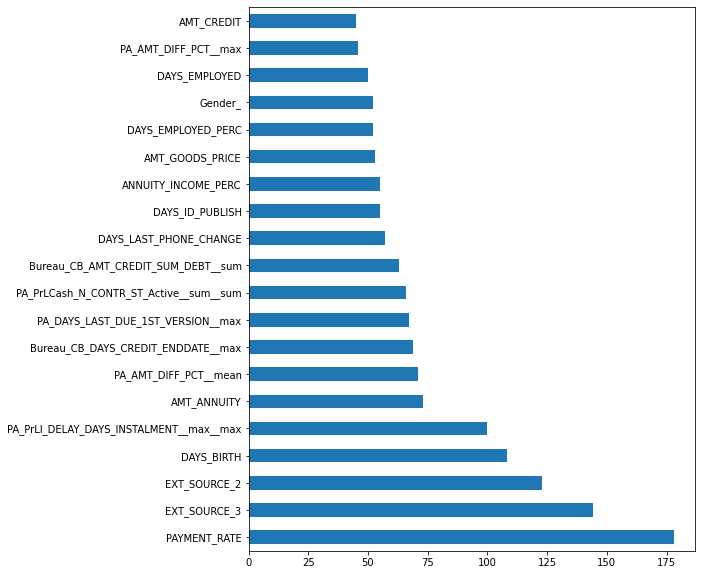

In [ ]:
feat_imp_fs.nlargest(20).plot(kind='barh', figsize=(8,10))

## `Feature Importance avec SHAP:`

In [ ]:
!pip install shap
import shap

In [ ]:
model_lgbm.fit(X_train_rus, y_train_rus)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LGBMClassifier(max_depth=12, min_child_samples=500, min_child_weight=0.3,
               random_state=42, reg_alpha=5, reg_lambda=3)

In [ ]:
print("Train Accuracy : ", model_lgbm.score(X_train_rus, y_train_rus))

Train Accuracy :  0.7448539778449144


In [ ]:
feat_imp = pd.Series(model_lgbm.feature_importances_, index=X_train_rus.columns)

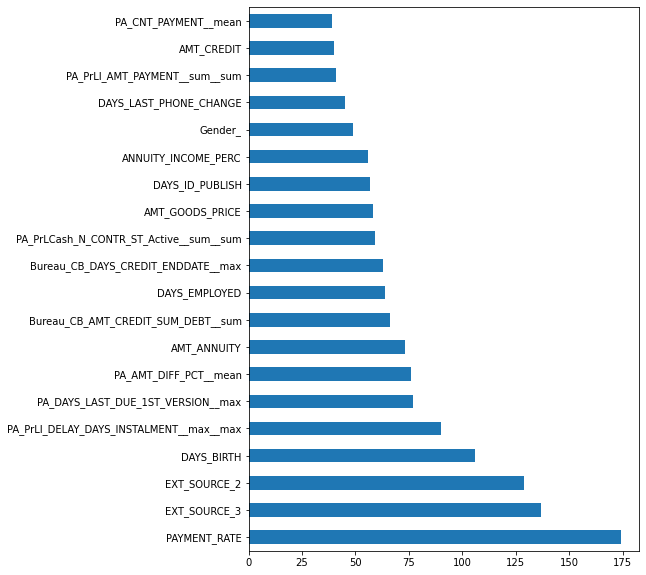

In [ ]:
feat_imp.nlargest(20).plot(kind='barh', figsize=(7,10))

In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()

In [ ]:
shap_values = shap.TreeExplainer(model_lgbm.booster_).shap_values(X_train_rus)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


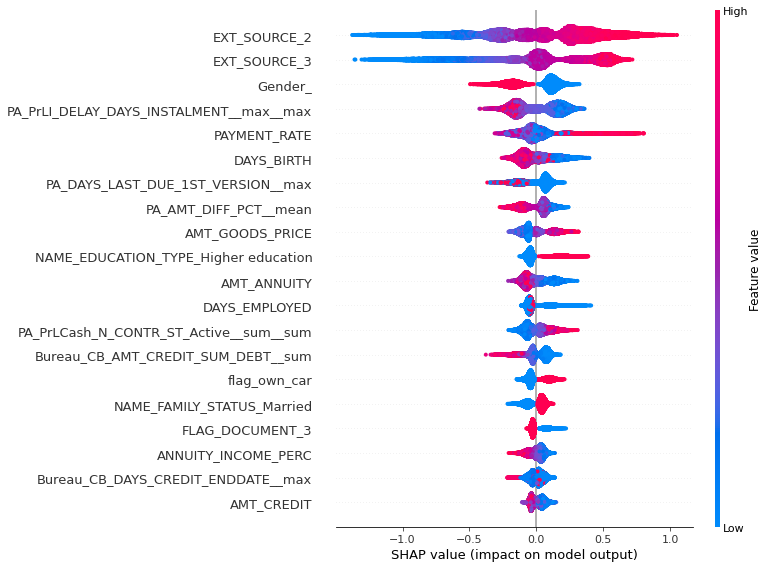

In [ ]:
shap.summary_plot(shap_values[0], X_train_rus)

In [ ]:
import warnings

explainer = shap.TreeExplainer(model_lgbm)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")


select = range(20)
features = X_train_rus.iloc[select]
features_display = X_train_rus.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-0.00383374]


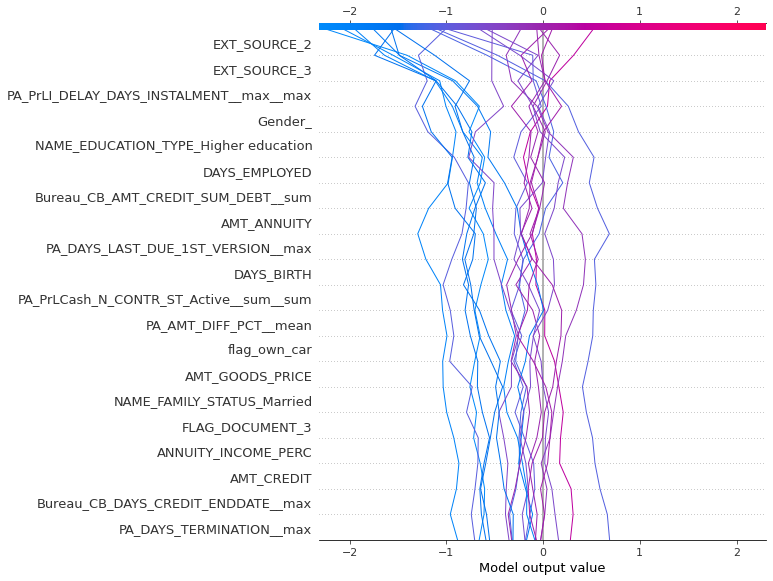

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

### `Comparaison entre les 10 principales variables:` 

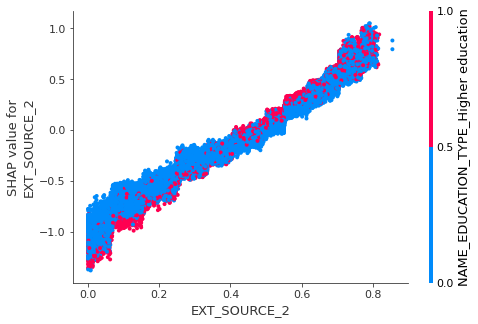

In [ ]:
shap.dependence_plot("EXT_SOURCE_2", shap_values[0], X_train_rus)

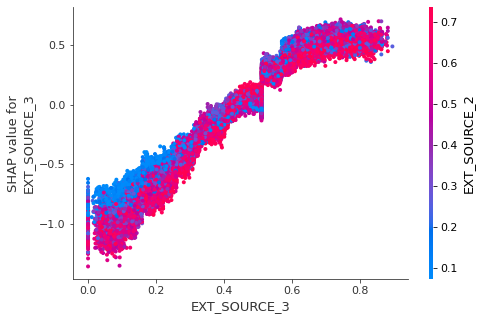

In [ ]:
shap.dependence_plot("EXT_SOURCE_3", shap_values[0], X_train_rus)

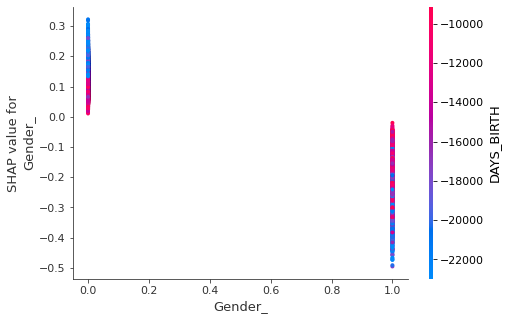

In [ ]:
shap.dependence_plot("Gender_", shap_values[0], X_train_rus)

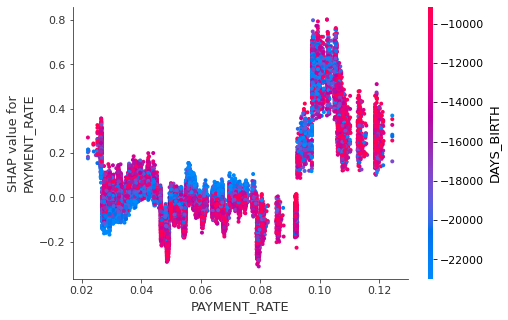

In [ ]:
shap.dependence_plot("PAYMENT_RATE", shap_values[0], X_train_rus)

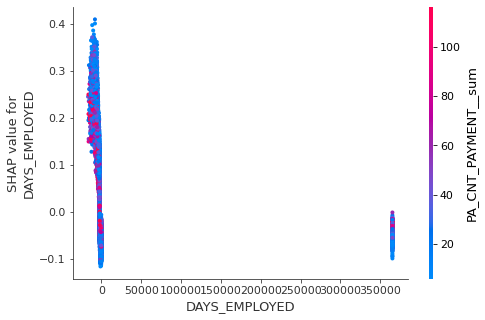

In [ ]:
shap.dependence_plot("DAYS_EMPLOYED", shap_values[0], X_train_rus)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[1][0,:], X_train_rus.iloc[0,:])

La figure au-dessus représente l’importance globale des variables calculées par les valeurs de Shap. Grâce au fait que les valeurs sont calculées pour chaque exemple du dataset, il est possible de représenter chaque exemple par un point (figure de droite) et ainsi avoir une information supplémentaire sur l’impact de la variable en fonction de sa valeur. Par exemple BUREAU_CB_AMT qui est la variable la plus importante, a un impact négatif quand la valeur de cette variable est élevée.


Explication d’impact des variables pour deux exemples du dataset. En rouge, les variables qui ont un impact positif (contribuent à ce que la prédiction soit plus élevée que la valeur de base) et, en bleu, celles ayant un impact négatif (contribuent à ce que la prédiction soit plus basse que la valeur de base)

Source: https://www.aquiladata.fr/insights/shap-mieux-comprendre-linterpretation-de-modeles/ 

# `7ème Partie: Optimisation du Threshold`


Dans cette étape on cherche à optmiszer le Threshold - le valeur limite qui separe la prediction en classes. On choisira le metrique f1_score pour choisir. 

L'objectif est de trouver le threshold optimale qui maximise f1_score par la validation croisée. 


Source : https://github.com/gianlucamalato/machinelearning/blob/master/Threshold.ipynb  et https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/ 

### `Calcul valeur idéal threshold`

In [ ]:
model_b = model_lgbm

In [ ]:
# Executer modèle sur le jeu de données balancé (X_train_rus_selector)
model_b.fit(X_train_rus, y_train_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(max_depth=12, min_child_samples=500, min_child_weight=0.3,
               random_state=42, reg_alpha=5, reg_lambda=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


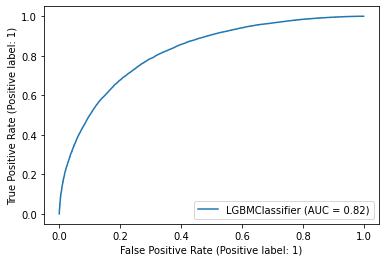

In [ ]:
from sklearn.metrics import roc_curve,plot_roc_curve, balanced_accuracy_score
plot_roc_curve(model_b,X_train_rus[mask],y_train_rus)

In [ ]:
threshold = []
accuracy = []

for p in np.unique(model_b.predict_proba(X_train_rus[mask])[:,1]):
  threshold.append(p)
  y_pred = (model_b.predict_proba(X_train_rus[mask])[:,1] >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_train_rus,y_pred))

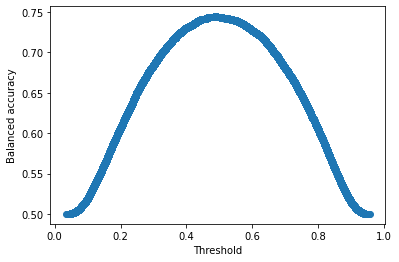

In [ ]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

In [ ]:
threshold[np.argmax(accuracy)] 
#En gros les personnes avec une probabilité de défaut de payement supérieur à 48.77 %  appartiennent au groupe de  clients à risque de défaut de payement. 

0.4877560710268804

### Calcul de la target predit et de la probabilité sur les jeu de données (entrainement et test)

In [ ]:
model_lgbm.fit(X_train_rus[mask], y_train_rus)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(max_depth=12, min_child_samples=500, min_child_weight=0.3,
               random_state=42, reg_alpha=5, reg_lambda=3)

In [ ]:
# Calculer le target_predi1 pour chacun des jeux de données:
y_target1_a = model_lgbm.predict(X_train[mask]) 
y_target1_b = model_lgbm.predict(X_test[mask])

In [ ]:
# Calculer la probabilité sur jeu d'entrainément total
y_proba_a = model_lgbm.predict_proba(X_train[mask])[:,1]
y_proba_b = model_lgbm.predict_proba(X_test[mask])[:,1]

# `8ème Partie: Sauvegarde du jeu des données` 


pour être utilisé pour le dashboard

### `Jeu d'entrainement`

In [ ]:
df_train_f = X_train.copy()

In [ ]:
df_train_f = df_train_f[mask]

In [ ]:
# Création des variables target et probabilité
df_train_f['target_predit1'] = y_target1_a
df_train_f['target_reel'] = y_train
df_train_f['probabilite_default'] = y_proba_a

In [ ]:
df_train_f[['target_predit1', 'target_reel', 'probabilite_default']].head(3)

,target_predit1,target_reel,probabilite_default
SK_ID_CURR,,,
100002,1,1,0.80
100003,0,0,0.15
100004,0,0,0.27


### `Jeu de test`

In [ ]:
df_test_f = X_test.copy()

In [ ]:
df_test_f = df_test_f[mask]

In [ ]:
df_test_f['target_predit1'] = y_target1_b
df_test_f['probabilite_default'] = y_proba_b

In [ ]:
df_test_f[['target_predit1', 'probabilite_default']].head(3)

,target_predit1,probabilite_default
SK_ID_CURR,,
100001,0,0.48
100005,1,0.71
100013,0,0.32


In [ ]:
X_train = X_train[mask]
X_test = X_test[mask]

In [ ]:
# sauvegarde dataframes: 

X_train_rus.to_csv('drive/My Drive/Projet_7/X_train_rus.csv')
y_train_rus.to_csv('drive/My Drive/Projet_7/y_train_rus.csv')
X_train.to_csv('drive/My Drive/Projet_7/X_train.csv')
X_test.to_csv('drive/My Drive/Projet_7/X_test.csv')
df_test_f.to_csv('drive/My Drive/Projet_7/df_test_f.csv')
df_train_f.to_csv('drive/My Drive/Projet_7/df_train_f.csv')